In [1]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
# Load Ground Truth Data
gt = []
with open("pandasDataset/groundtruth.txt", 'r') as f:
    for line in f:
        values = line.strip().split(',')
        values = [int(float(v)) for v in values]
        gt.append(values)   

In [3]:
# Initializing Video Capture
vid_path = 'output.mp4'
cap = cv2.VideoCapture(vid_path)
if not cap.isOpened():
    raise RuntimeError("Failed to open video file")

ret, prev_frame = cap.read()
if not ret:
    raise RuntimeError("Failed to read first frame")

# Tracking Initialization

In [4]:
# setting parametesd for future detection and tracking
ST_PARAMS = dict(
    maxCorners=10,
    qualityLevel=0.3,
    minDistance=7,
    blockSize=7
)

LK_PARAMS = dict(
    winSize=(20, 20),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT,10,0.03)
)

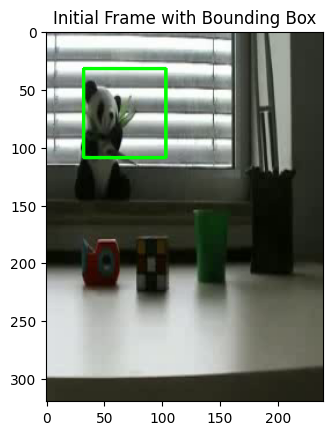

In [5]:
# initialize ROI from Ground Truth
x, y, w, h = map(int, gt[0][:4])

frame_with_bbox = prev_frame.copy()
cv2.rectangle(frame_with_bbox, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Display the annotated frame
plt.imshow(cv2.cvtColor(frame_with_bbox, cv2.COLOR_BGR2RGB))
plt.title("Initial Frame with Bounding Box")
plt.show()

In [6]:
# Prepare ROI and Feature Points
# Crop the ROI and convert to grayscale
roi = prev_frame[y:y+h, x:x+w]
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
# Detect features in the entire frame
all_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, **ST_PARAMS)

In [7]:
# Filter features inside the initial bounding box
selected_points = []
for point in all_points:
    px, py = point.ravel()
    if x <= px <= x+w and y <= py <= y+h:
        selected_points.append(point)
if not selected_points:
    raise RuntimeError("No features found in the initial bounding box!")

prevPts = np.array(selected_points, dtype=np.float32) # Format for tracking

In [ ]:
# Initialize Video Writer Output
# Get video properties from the input
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Define output file and codec (MP4 format)
output_path = '/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for MP4 format
# Initialize VideoWriter
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Create a black mask (same size as input frames)
mask = np.zeros_like(prev_frame)
# Track frame count for debugging/analysis
frame_count = 0

# Object Tracking Loop with Optical Flow

In [9]:
# Initial Setup
import time
start_time = time.time()

# Frame Processing Loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Optical Flow Calculation
    if prevPts is not None:
        nextPts, status, _ = cv2.calcOpticalFlowPyrLK(
            prev_gray, frame_gray, prevPts, None, **LK_PARAMS
        )
        if nextPts is not None:
            good_new = nextPts[status == 1]
            good_prev = prevPts[status == 1]

            for (new, prev) in zip(good_new, good_prev):
                x_new, y_new = new.ravel()
                x_prev, y_prev = prev.ravel()

                x_new, y_new = map(int, (x_new, y_new))
                x_prev, y_prev = map(int, (x_prev, y_prev))

                frame = cv2.circle (frame, (x_new, y_new), 5, (0, 255, 0), -1)

                # Performance Metrics and Output
                visualized_frame = cv2.add(frame, mask)

                elapsed_time = time.time() -  start_time
                fps = frame_count/elapsed_time if elapsed_time > 0 else 0
                cv2.putText(
                    visualized_frame,
                    f"FPS: {fps:.2f}",
                    (width-200, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (255, 0, 0), 2, cv2.LINE_AA
                )

                out.write(visualized_frame)
                prevPts = good_new.reshape(-1, 1, 2)
        else:
            out.write(frame)
            prevPts = None
    else:    
        out.write(frame)
    
    prev_gray = frame_gray.copy()
    frame_count += 1

cap.release()
out.release()

cv2.destroyAllWindows()

print(f"Processing complete. Output saved to {output_path}")



Processing complete. Output saved to output_video.mp4
